In [1]:
"""\
This script contains all the functions used to generate P(s) curves in the paper "Dynamics of microcompartment formation at the mitosis-to-G1 transition".

Author: Viraat Goel
"""

%load_ext autoreload
%autoreload 2

In [2]:
# import core packages
import warnings
warnings.filterwarnings("ignore")
from itertools import combinations

# import semi-core packages
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
plt.style.use('seaborn-poster')
import numpy as np
import pandas as pd

# import open2c libraries
import bioframe

import cooler
import cooltools

from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.0'):
    raise AssertionError("tutorials rely on cooltools version 0.5.0 or higher,"+
                         "please check your cooltools version and update to the latest")

In [3]:
# Load in mcools at desired resolutions
resolution = 150 # 1kb res might be slightly slow on a laptop
                  # and could be lowered to 10kb for increased speed
clrRCMC_PM = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_AT = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_EG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_MG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_LG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))
clrRCMC_Asyn = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resolution))

# Use bioframe to fetch the genomic features from the UCSC
mm39_chromsizes = bioframe.fetch_chromsizes('mm39')
df_mm39 = pd.DataFrame.from_dict(mm39_chromsizes).reset_index(level=0)
df_mm39 = df_mm39.rename(columns={"index": "chrom", "length": "end"})
df_mm39['start'] = 0
df_mm39['name'] = df_mm39['chrom']
df_mm39 = df_mm39[['chrom', 'start', 'end', 'name']]
df_mm39

# Generate cis-expected values for each cooler
cvd_smooth_agg_RCMC_ProMeta = cooltools.expected_cis(
    clr=clrRCMC_ProMeta,
    view_df=df_mm39,
    smooth=True,
    aggregate_smoothed=True,
    nproc=16
)

cvd_smooth_agg_RCMC_AnaTelo = cooltools.expected_cis(
    clr=clrRCMC_AnaTelo,
    view_df=df_mm39,
    smooth=True,
    aggregate_smoothed=True,
    nproc=16
)

cvd_smooth_agg_RCMC_EarlyG1 = cooltools.expected_cis(
    clr=clrRCMC_EarlyG1,
    view_df=df_mm39,
    smooth=True,
    aggregate_smoothed=True,
    nproc=16
)

cvd_smooth_agg_RCMC_MidG1 = cooltools.expected_cis(
    clr=clrRCMC_MidG1,
    view_df=df_mm39,
    smooth=True,
    aggregate_smoothed=True,
    nproc=16
)

cvd_smooth_agg_RCMC_LateG1 = cooltools.expected_cis(
    clr=clrRCMC_LateG1,
    view_df=df_mm39,
    smooth=True,
    aggregate_smoothed=True,
    nproc=16
)

cvd_smooth_agg_RCMC_Async = cooltools.expected_cis(
    clr=clrRCMC_Async,
    view_df=df_mm39,
    smooth=True,
    aggregate_smoothed=True,
    nproc=16
)

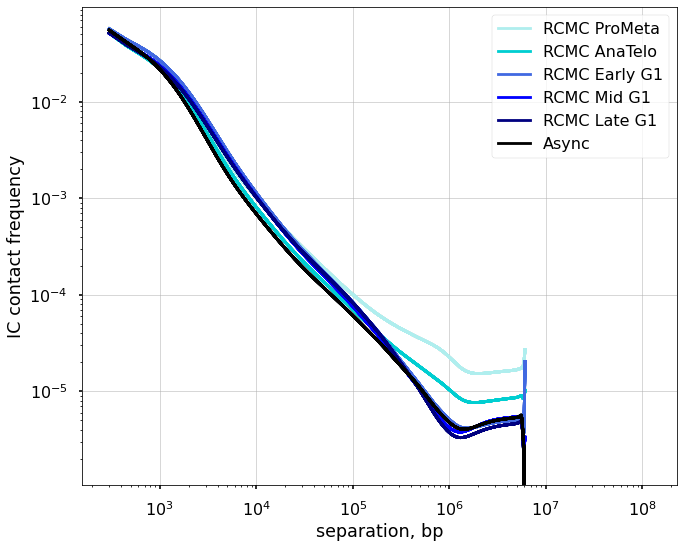

In [4]:
# Generate balanced and smoothed P/S curves
f, ax = plt.subplots(1,1)

cvdCombined = [cvd_smooth_agg_RCMC_ProMeta, cvd_smooth_agg_RCMC_AnaTelo, cvd_smooth_agg_RCMC_EarlyG1, cvd_smooth_agg_RCMC_MidG1, cvd_smooth_agg_RCMC_LateG1, cvd_smooth_agg_RCMC_Async]
colors = ['paleturquoise', 'darkturquoise', 'royalblue', 'blue', 'navy', 'black']
labels = ['RCMC ProMeta', 'RCMC AnaTelo', 'RCMC Early G1', 'RCMC Mid G1', 'RCMC Late G1', 'Async']
i = 0
newLine = 0

for cvd_smooth_agg in cvdCombined:
    
    cvd_smooth_agg['s_bp'] = cvd_smooth_agg['dist'] * resolution
    cvd_smooth_agg['balanced.avg.smoothed.agg'].loc[cvd_smooth_agg['dist'] < 2] = np.nan

    for region in df_mm39['name']:
        ax.loglog(
            cvd_smooth_agg['s_bp'].loc[cvd_smooth_agg['region1']==region],
            cvd_smooth_agg['balanced.avg.smoothed.agg'].loc[cvd_smooth_agg['region1']==region],
            color = colors[i],
            label = "_" + labels[i]
        )
    ax.properties()['children'][newLine].set_label(labels[i])
    
    newLine = len(ax.properties()['children'])
    i += 1
    
ax.set(
    xlabel='separation, bp',
    ylabel='IC contact frequency')
ax.set_aspect(1.0)
ax.grid(lw=0.5)
ax.legend()

In [5]:
# Drop rows > 1 Mb apart in the captured datasets since most ROIs are 1 Mb in size and the data become sparse & noisy at larger length scales
"1 Mb = 1,000,000 bp / 150bp resolution = 6667 distance cutoff"
cvd_smooth_agg_RCMC_ProMeta_trunc = cvd_smooth_agg_RCMC_ProMeta[cvd_smooth_agg_RCMC_ProMeta['dist'] <= 6667]
cvd_smooth_agg_RCMC_AnaTelo_trunc = cvd_smooth_agg_RCMC_AnaTelo[cvd_smooth_agg_RCMC_AnaTelo['dist'] <= 6667]
cvd_smooth_agg_RCMC_EarlyG1_trunc = cvd_smooth_agg_RCMC_EarlyG1[cvd_smooth_agg_RCMC_EarlyG1['dist'] <= 6667]
cvd_smooth_agg_RCMC_MidG1_trunc = cvd_smooth_agg_RCMC_MidG1[cvd_smooth_agg_RCMC_MidG1['dist'] <= 6667]
cvd_smooth_agg_RCMC_LateG1_trunc = cvd_smooth_agg_RCMC_LateG1[cvd_smooth_agg_RCMC_LateG1['dist'] <= 6667]
cvd_smooth_agg_RCMC_Async_trunc = cvd_smooth_agg_RCMC_Async[cvd_smooth_agg_RCMC_Async['dist'] <= 6667]

In [ ]:
# Just take a single value for each genomic separation
cvd_merged_RCMC_ProMeta = cvd_smooth_agg_RCMC_ProMeta_trunc.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
cvd_merged_RCMC_AnaTelo = cvd_smooth_agg_RCMC_AnaTelo_trunc.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
cvd_merged_RCMC_EarlyG1 = cvd_smooth_agg_RCMC_EarlyG1_trunc.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
cvd_merged_RCMC_MidG1 = cvd_smooth_agg_RCMC_MidG1_trunc.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
cvd_merged_RCMC_LateG1 = cvd_smooth_agg_RCMC_LateG1_trunc.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]
cvd_merged_RCMC_Async = cvd_smooth_agg_RCMC_Async_trunc.drop_duplicates(subset=['dist'])[['s_bp', 'balanced.avg.smoothed.agg']]

# Calculate derivative in log-log space
derProMeta = np.gradient(np.log(cvd_merged_RCMC_ProMeta['balanced.avg.smoothed.agg']),np.log(cvd_merged_RCMC_ProMeta['s_bp']))
derAnaTelo = np.gradient(np.log(cvd_merged_RCMC_AnaTelo['balanced.avg.smoothed.agg']),np.log(cvd_merged_RCMC_AnaTelo['s_bp']))
derEarlyG1 = np.gradient(np.log(cvd_merged_RCMC_EarlyG1['balanced.avg.smoothed.agg']),np.log(cvd_merged_RCMC_EarlyG1['s_bp']))
derMidG1 = np.gradient(np.log(cvd_merged_RCMC_MidG1['balanced.avg.smoothed.agg']),np.log(cvd_merged_RCMC_MidG1['s_bp']))
derLateG1 = np.gradient(np.log(cvd_merged_RCMC_LateG1['balanced.avg.smoothed.agg']),np.log(cvd_merged_RCMC_LateG1['s_bp']))
derAsync = np.gradient(np.log(cvd_merged_RCMC_Async['balanced.avg.smoothed.agg']),np.log(cvd_merged_RCMC_Async['s_bp']))

cvdCombined = [cvd_smooth_agg_RCMC_ProMeta_trunc, cvd_smooth_agg_RCMC_AnaTelo_trunc, cvd_smooth_agg_RCMC_EarlyG1_trunc, cvd_smooth_agg_RCMC_MidG1_trunc, cvd_smooth_agg_RCMC_LateG1_trunc]
derCombined = [derProMeta, derAnaTelo, derEarlyG1, derMidG1, derLateG1]
colors = ['paleturquoise', 'darkturquoise', 'royalblue', 'blue', 'navy']
labels = ['RCMC ProMeta', 'RCMC AnaTelo', 'RCMC Early G1', 'RCMC Mid G1', 'RCMC Late G1']
i = 0
newLine = 0

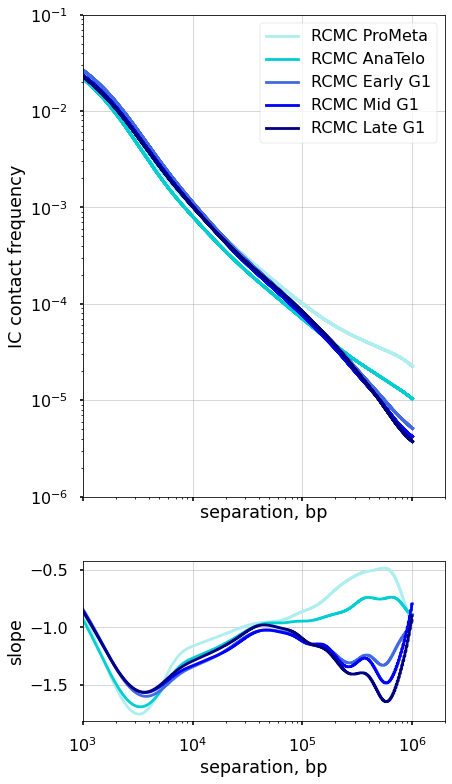

In [9]:
# Plot balanced and smoothed P/S curves plus derivative plot for genomic distances limited to the size of the ROIs
f, axs = plt.subplots(
    figsize=(6.5,13),
    nrows=2,
    gridspec_kw={'height_ratios':[6,2]},
    sharex=True)

# Part 1: the P(s) curves
ax = axs[0]

for cvd_smooth_agg in cvdCombined:
    
    cvd_smooth_agg['s_bp'] = cvd_smooth_agg['dist'] * resolution
    cvd_smooth_agg['balanced.avg.smoothed.agg'].loc[cvd_smooth_agg['dist'] < 2] = np.nan

    for region in df_mm39['name']:
        ax.loglog(
            cvd_smooth_agg['s_bp'].loc[cvd_smooth_agg['region1']==region],
            cvd_smooth_agg['balanced.avg.smoothed.agg'].loc[cvd_smooth_agg['region1']==region],
            color = colors[i],
            label = "_" + labels[i]
        )
    ax.properties()['children'][newLine].set_label(labels[i])
    
    newLine = len(ax.properties()['children'])
    i += 1
    
ax.set(
    xlabel='separation, bp',
    ylabel='IC contact frequency')
ax.grid(lw=0.5)
ax.set_xlim(left=1000) # Toggle this to truncate small distances
ax.set_xlim(right=2000000)
ax.set_ylim(top=0.1)
ax.set_ylim(bottom=0.000001)
ax.legend()

# Part 2: the P(s) derivative plot:
ax = axs[1]
i = 0
newLine = 0

for der in derCombined:
    ax.semilogx(
        cvd_merged_RCMC_ProMeta['s_bp'],
        der,
        color = colors[i],
        label = "_" + labels[i]
    )
    ax.properties()['children'][newLine].set_label(labels[i])
    newLine = len(ax.properties()['children'])
    i += 1

ax.set(
    xlabel='separation, bp',
    ylabel='slope')
ax.grid(lw=0.5)

plt.savefig('SAVE_DIRECTORY/FILE_NAME.svg', dpi=1200) # swap out .svg for the desired output file format